# Model Training

## Table of Contents
- Data Preparation
- Modelling
    - ARIMA
    - Random Forest
    - XGBoost
- Comparison of Models
- Results

<br>

---

### Data preparation

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data/cleaned_df_v2.csv", index_col=False)
df = df.iloc[: , 1:]

# convert date
df['year_month'] = pd.to_datetime(df['year_month'])
df['year'] = df['year_month'].dt.year
df['month'] = df['year_month'].dt.month

In [59]:
from sklearn.model_selection import train_test_split

features = ['year', 'month', 'us_state', 'make', 'phone_series',  'model_family','model_age_months', 
            'predecessor', 'successor', 'model', 'sku', 'sku_no_colour', 'colour', 'size', 'claims', 
            'ir_rate_swap', 'ir_rate_replacement', 'ir_rate_monthly', 'churn_rate'] # 19 features
target = 'closing_subs_monthly'
categorical_cols = ["us_state", "make", "phone_series", "model_family", "colour", "size"]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )

X_train.head()

,year,month,us_state,make,phone_series,model_family,model_age_months,predecessor,successor,model,sku,sku_no_colour,colour,size,claims,ir_rate_swap,ir_rate_replacement,ir_rate_monthly,churn_rate
6615,2023,6,Nevada,Apple,IPHONE 12,APPLE IPHONE 12 PRO MAX,31,APPLE IPHONE 11 PRO MAX,APPLE IPHONE 13 PRO MAX,IPHONE 12 PRO MAX 5G 256GB GRAPHITE,IPH12PRM5G256GRY,IPH12PRM5G256,Gray,256,3.0,0.0,0.0,0.001585,0.049128
9440,2023,5,Nevada,Apple,IPHONE XR,APPLE IPHONE XR,55,APPLE IPHONE X,APPLE IPHONE 11,IPHONE XR 64GB BLACK,IPHXR64BLK,IPHXR64,Black,64,0.0,0.0,0.0,0.000000,0.055838
1549,2022,12,Texas,Oppo,OPPO A90,OPPO A94,21,First Model,Last Model,A94 128GB SILVER,A94128SIL,A94128,Silver,128,0.0,0.0,0.0,0.000000,0.073171
10717,2019,9,Nevada,Samsung,SAMSUNG GALAXY NOTE 9,SAMSUNG GALAXY NOTE 9,13,First Model,Last Model,GALAXY NOTE 9 128GB BLACK,NOTE9128BLK,NOTE9128,Black,128,16.0,0.0,0.0,0.002614,0.035778
3034,2021,4,California,Samsung,GALAXY S21,SAMSUNG GALAXY S21 PLUS,14,SAMSUNG GALAXY S20 PLUS,SAMSUNG GALAXY S22 PLUS,GALAXY S21 PLUS 5G 256GB BLACK,GXYS21P5G256BLK,GXYS21P5G256,Black,256,0.0,0.0,0.0,0.000000,0.027237


<br>

---

## Time series model: ARIMA (AutoRegressive Integrated Moving Average)

Data preparation

In [60]:
# Split the data into training and test sets
train_data = df[df['year_month'] < '2023-01-01']  # Data up to January 2023
test_data = df[df['year_month'] >= '2023-01-01']  # Data from January 2023 onwards

In [61]:
# Sort by 'year' and 'month'
train_data['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Group data by month (sum or average closing_subs_monthly)
monthly_data = train_data.groupby('year_month')['closing_subs_monthly'].mean()
monthly_data.head()

year_month
2019-01-01    3450.818182
2019-02-01    3600.375000
2019-03-01    3922.367647
2019-04-01    4268.375000
2019-05-01    4317.015385
Name: closing_subs_monthly, dtype: float64

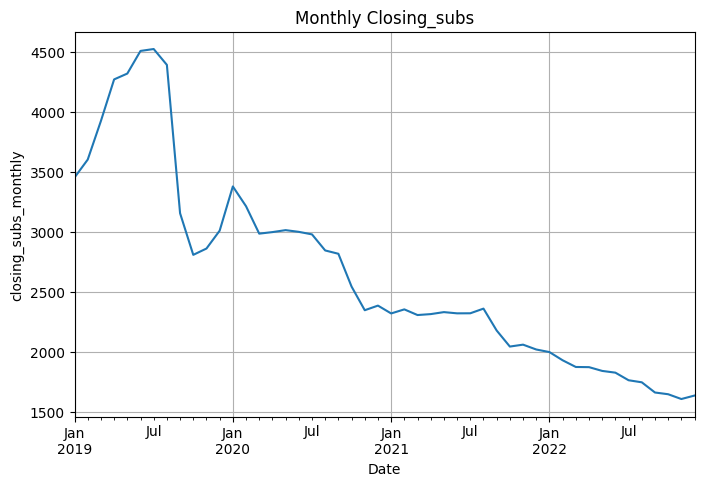

In [62]:
# Plot closing_subs_monthly VS Date
plt.figure(figsize=(8, 5))
monthly_data.plot()
plt.title('Monthly Closing_subs')
plt.xlabel('Date')
plt.ylabel('closing_subs_monthly')
plt.grid(True)
plt.show()

Overall, we observe that the number of closing subscriptions rises to a peak around July 2019 before subsequently declining.

In [63]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(monthly_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value < 0.05, the series is stationary

ADF Statistic: -2.2918725497026164
p-value: 0.1746026361138598


In [64]:
# Differencing the data to make it stationary
monthly_data_diff = monthly_data.diff().dropna()

# Check stationarity again
result_diff = adfuller(monthly_data_diff)
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -4.425855757441596
p-value (Differenced): 0.0002670718409043239


Now that the data is stationary, we can fit the ARIMA model.

In [65]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(monthly_data, order=(5, 1, 0))  # p=5, d=1, q=0 (can fine tune)
model_fit = model.fit()

# Summarize the model
# model_fit.summary()

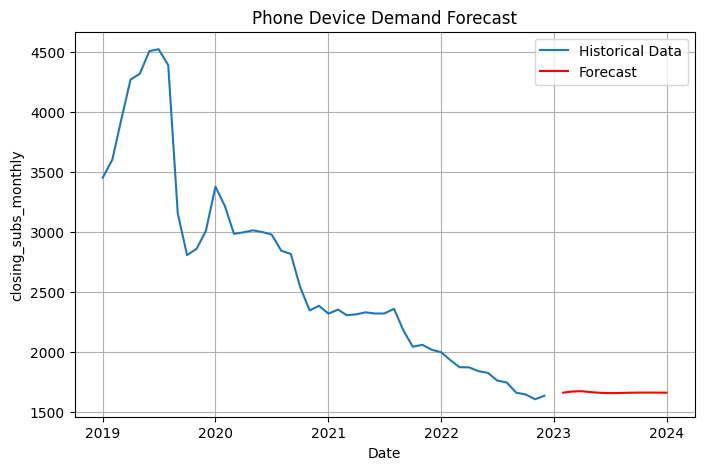

In [66]:
# Forecast plot for the next 12 months
forecast = model_fit.forecast(steps=12)

# Plot the forecast
plt.figure(figsize=(8, 5))
plt.plot(monthly_data.index, monthly_data, label='Historical Data')
plt.plot(pd.date_range(monthly_data.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='red')
plt.title('Phone Device Demand Forecast')
plt.xlabel('Date')
plt.ylabel('closing_subs_monthly')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

forecast = model_fit.forecast(steps=11)
test_data_output = test_data.groupby('year_month')['closing_subs_monthly'].mean()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data_output, forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data_output, forecast))

# Print the results
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 254.49312045145754
RMSE: 279.6964493524239


### Phone demand forcast for the next 2 months Dec 2023 and Jan 2025

In [68]:
# Sort by 'year' and 'month'
train_data = df.copy()
train_data['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Group data by month (sum or average closing_subs_monthly)
monthly_data = train_data.groupby('year_month')['closing_subs_monthly'].mean()
monthly_data.head()

year_month
2019-01-01    3450.818182
2019-02-01    3600.375000
2019-03-01    3922.367647
2019-04-01    4268.375000
2019-05-01    4317.015385
Name: closing_subs_monthly, dtype: float64

In [69]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(monthly_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value < 0.05, the series is stationary

ADF Statistic: -2.9589083271651093
p-value: 0.038914141278406124


In [70]:
# Differencing the data to make it stationary
monthly_data_diff = monthly_data.diff().dropna()

# Check stationarity again
result_diff = adfuller(monthly_data_diff)
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -5.286266281053599
p-value (Differenced): 5.845965845277316e-06


In [71]:
# Fit ARIMA model for all data in df
model = ARIMA(monthly_data, order=(5, 1, 0))  # p=5, d=1, q=0 (can fine tune)
model_fit = model.fit()

future_forecast = model_fit.forecast(steps=2) 
print(f"Future forecasted demand for Dec 2023 and Jan 2025: \n{future_forecast}")

Future forecasted demand for Dec 2023 and Jan 2025: 
2023-12-01    1203.898602
2024-01-01    1213.028720
Freq: MS, Name: predicted_mean, dtype: float64


<br>

---

## RandomForestRegressor to predict closing_subs_monthly

In [72]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  
    ])

# Define the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42)) 
])

# Model training
model_pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model_pipeline.predict(X_test)

# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1870.7079620144557


### Phone demand forcast for the next 2 months Dec 2023 and Jan 2025

In [73]:
# Create a DataFrame for the next 2 months
future_months_data = pd.DataFrame({
    'year': [2023, 2024],  # Next 2 months (2025)
    'month': [12, 1],       # January and February
    'us_state': ['California', 'California'],  # 2 values, one for each month
    'make': ['Apple', 'Apple'],
    'phone_series': ['IPHONE 12', 'IPHONE 12'],
    'model_family': ['APPLE IPHONE 12 PRO MAX', 'APPLE IPHONE 12 PRO MAX'],
    'colour': ['Gray', 'Gray'],
    'size': [256, 256],
    'model_age_months': [31, 31],
    'predecessor': ['APPLE IPHONE 11 PRO MAX', 'APPLE IPHONE 11 PRO MAX'],
    'successor': ['APPLE IPHONE 13 PRO MAX', 'APPLE IPHONE 13 PRO MAX'],
    'model': ['IPHONE 12 PRO MAX 5G 256GB GRAPHITE', 'IPHONE 12 PRO MAX 5G 256GB GRAPHITE'],
    'sku': ['IPH12PRM5G256GRY', 'IPH12PRM5G256GRY'],
    'sku_no_colour': ['IPH12PRM5G256', 'IPH12PRM5G256'],
    'claims': [3.0, 3.0],
    'ir_rate_swap': [0.0, 0.0],
    'ir_rate_replacement': [0.0, 0.0],
    'ir_rate_monthly': [0.001585, 0.001585],
    'churn_rate': [0.049128, 0.049128]
})

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model_pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model_pipeline.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Predict the closing_subs_monthly for the next 2 months
future_predictions = model_pipeline.predict(future_months_data)

# Display the predicted closing_subs_monthly for the next 2 months
print(f'Predicted closing_subs_monthly for Dec 2023 and Jan 2024: {future_predictions}')


Mean Squared Error: 3499548.2791442783
Root Mean Squared Error (RMSE): 1870.7079620144557
Predicted closing_subs_monthly for Dec 2023 and Jan 2024: [1199.25661648 1199.25661648]


<br>

---

## XGBoost

XGBoost is an ensemble learning method that combines the predictions of multiple weak models (decision trees) to create a strong predictive model.

In [74]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(X_train)

Using GridSearch CV to find the best hyperparameters

In [75]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the column transformer with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols)
    ]
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Create the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=3244)

# Fit the model to the training data
model.fit(X_train_processed, y_train)

# Evaluate the model on the test data (transforming the test data using the already fitted preprocessor)
X_test_processed = preprocessor.transform(X_test)
y_pred = model.predict(X_test_processed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train_processed, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test_processed)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Squared Error: 3497814.339077712
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Mean Squared Error: 3502797.2223229036
Root Mean Squared Error (RMSE): 1871.5761331890571


### Phone demand forcast for the next 2 months Dec 2023 and Jan 2025

In [76]:
# Ensure all categorical columns are included and consistent with the training data
future_months_data_processed = preprocessor.transform(future_months_data)

# Make predictions using the best model
future_predictions = best_model.predict(future_months_data_processed)

# Display the predicted closing_subs_monthly for the next 2 months
print(f'Predicted closing_subs_monthly for Dec 2023 and Jan 2024: {future_predictions}')

Predicted closing_subs_monthly for Dec 2023 and Jan 2024: [1202.2214 1202.2214]


---

<br>


# Model Comparison

### Predicted closing_subs_monthly for Dec 2023 and Jan 2024 for the 3 models are: 
ARIMA:
- December 2023: 1203.90
- January 2024: 1213.03

Random Forest:
- December 2023: 1199.26
- January 2024: 1199.26 (constant prediction)

XGBoost:
- December 2023: 1202.22
- January 2024: 1202.22 (constant prediction)

**_Observations_**  
ARIMA Model Trends:
The ARIMA model predicts a gradual increase in closing subscriptions from December to January, suggesting a positive trend in subscriber growth during this period. The increase from approximately 1203.90 to 1213.03 indicates a potential seasonal effect or other influencing factors that may contribute to this growth.

Random Forest Predictions:
The Random Forest model predicts a consistent number of closing subscriptions for both months at approximately 1199.26. This lack of variation suggests that the model may not be capturing any seasonal trends or fluctuations effectively, which could indicate that it is overly simplistic for this dataset.

XGBoost Predictions:
Similar to the Random Forest model, XGBoost predicts a constant value of approximately 1202.22 for both months. This indicates stability in the predictions but may also suggest that the model is not responsive to changes or trends in the data during this time frame.

Model Comparison:
The ARIMA model appears to be the most responsive to changes in the data, predicting an increase in subscriptions, while both Random Forest and XGBoost provide stable predictions without any growth.

### Model Evaluation  
- **ARIMA:**   
MAE: 254.49  
RMSE: 279.70    

- **RandomForest:**   
Mean Squared Error: 3499548.28    
Root Mean Squared Error (RMSE): 1870.71   

- **XGBoost:**  
Mean Squared Error: 3502797.22  
Root Mean Squared Error (RMSE): 1871.58  